# Coursework for Artificial Intelligence M COMPSCI5087 2024-2025

## Imports

In [1]:
import os, sys
import networkx as nx
import json
import numpy as np

from matplotlib import use
import matplotlib.pyplot as plt
import ipywidgets as widgets
use("Agg")

import warnings
warnings.filterwarnings("ignore")

import maze as m
import solvers as solv

print("Python version:", sys.version)
print("Networkx version:", nx.__version__)
print("IPyWidgets version:", widgets.__version__)

%load_ext autoreload
%autoreload 2

Python version: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:29:38) [GCC 11.2.0]
Networkx version: 3.4.2
IPyWidgets version: 8.1.5


## Parameters

In [2]:
# N = [11] # Growing number of tiles on the side
N = 31 # Growing number of tiles on the side
M = np.arange(11) # Fixed number of wormholes

n_repetitions = 20
folder = "M01"

## Setup

In [3]:
results_dir = "solved"
series_dir = os.path.join(results_dir, folder)
if not os.path.isdir(results_dir): os.mkdir(results_dir)
if not os.path.isdir(series_dir): os.mkdir(series_dir)

filepath = lambda M, label, k, extension : os.path.join(series_dir, f"{label}_{M:02.0f}_{k:02.0f}.{extension}")

## Problem Description

Important personal interpretation
- I am assuming that going down a teleportation link is optional: e.g. in (2,1) it's possible to go right, go left, or go down the teleportation link.
- I am assuming that the wormholes are one-ways passages: e.g. from (2,1) you can go down the teleportation link to (0,7), but from (0,7) you can't go to (2,1).

Important properties
- Branching factor? $b=5$, due to the 5 possible actions; could be optimistically lowered to 3 for most cases, since most tiles are only connected to 2 neighbours.
- Depth of the solution? $d\leq 4(N-2)$ with no teleportation links, effectively less with teleportation links

## Solver description

The **heuristic function** $h$ is an arbitrary, non-negative, problem-specific function with one constrain: if $n$ is a goal node, then $h(n)=0$.

_The tree-search version of A-star is optimal if the heuristic function is **admissible**_. 

A heuristic function is admissible if it never overestimates the cost to reach a goal, i.e. an admissible h is optimistic, returning the estimated cost of the cheapest/shortest path from a state to the goal.

An agent at the start of a teleportation link can choose to go down the wormhole. However, it cannot know in advance where the exit is. _The most optimistic agent going down a wormhole will always assume that a wormhole can take you right to the exit._

_The graph-search version of A-star is optimal if the heuristic function is **consistent**_. 

A heuristic function is consistent if, for every node $n$ and every successor $n'$ of $n$ generated by any action $a$, the estimated cost of reaching the goal from $n$ is no greater than the step cost of getting to $n'$ plus the estimated cost of reaching the goal from $n'$:

$h(n) \leq c(n,a,n') + h(n')$

This is a form of the general triangle inequality. 

"For an admissible heuristic, the inequality makes perfect sense: if there were a route from $n$ to $G_n$ via $n'$ that was cheaper than $h(n)$, that would violate the property that $h()n)$is a lower bound on the cost to reach $G_n$" (Russel, S, & Norvig, P.: _Artificial Intelligence: A Modern Approach_, 3rd edition, Pearson Education, 2010, USA)

If $h$ is consistent, then the values of $f(n)$ along any path are nondecreasing.

My heuristic function $h(n_i)=h(n_i,n_{i-1},n_{i-2})$ is consistent, as it is defined by pieces according to three cases:

- For any tile $n_i$ that is neither the entrance nor the exit of a wormhole, $h(n_i)$ returns the Euclidean distance to the goal
- For any tile $n_i$ that is the entrance of a wormhole, $h(n_i)=h(n_{i-1})-c$ is returned so that $f(n_i)=f(n_{i-1})$ matches its parent's because $f(n_i)=h(n_i)+g(n_i)=h(n_i)+g(n_{i-1})+c$
- For any tile $n_i$ that is the exit of a wormhole, $h(n_i)=h(n_{i-2})-2c$ is returned so that $f(n_i)=f(n_{i-1})=f(n_{i-2})$ matches both its parent's and its grandparent's because $f(n_i)=f(n_{i-1})$ and $f(n_i)=h(n_i)+g(n_i)=h(n_i)+g(n_{i-1})+c=h(n_i)+g(n_{i-2})+2c$

## Experiment

In [4]:
problem_branching_factors = []
problem_n_nodes = []

solution_n_steps = []
solution_depths = []
solution_n_frontier = []
solution_n_explored = []

In [5]:
for t in M:

    problem_branching_factors.append([])
    problem_n_nodes.append([])

    solution_n_steps.append([])
    solution_depths.append([])
    solution_n_frontier.append([])
    solution_n_explored.append([])

    for k in range(n_repetitions):

        print(f"> Maze with {t} teleportation links > Repetition {k}")

        maze_problem = m.wormholes_maze_problem(N, t, show_plots=True)
        plt.savefig(filepath(t, "maze", k, "png"))
        plt.close()

        branching_factor = max([len(v) for (k,v) in maze_problem.graph.graph_dict.items()])
        problem_branching_factors[-1].append(branching_factor)
        problem_n_nodes[-1].append( len(maze_problem.graph.locations) )

        n_steps, solution_path, all_node_colors = solv.wormholes_maze_A_star_solver(maze_problem, verbose=False, limit=1500)

        print(f"Solved in {n_steps} iterations")

        solution_n_steps[-1].append(n_steps)
        solution_depths[-1].append(len(solution_path))

        with open(filepath(t, "path", k, "json"), 'w', encoding='utf-8') as f:
            json.dump(dict(solution_path=[node.state for node in solution_path]), f, 
                      ensure_ascii=False, indent=4)
            
        print("Saved solution path")

        n_frontier = sum([v=="orange" for v in all_node_colors[-1].values()])
        n_explored = sum([v in ["limegreen","gray"] for v in all_node_colors[-1].values()])
        solution_n_frontier[-1].append(n_frontier)
        solution_n_explored[-1].append(n_explored)
        
        print("Added all results to lists")

        m.show_wormholes_maze_problem(maze_problem, all_node_colors[-1], n_steps)
        fig = plt.savefig(filepath(t, "solution", k, "png"))
        plt.close(fig)

        print("Plotted")

> Maze with 0 teleportation links > Repetition 0
Solved in 601 iterations
Saved solution path
Added all results to lists
Plotted
> Maze with 0 teleportation links > Repetition 1
Solved in 320 iterations
Saved solution path
Added all results to lists
Plotted
> Maze with 0 teleportation links > Repetition 2
Solved in 470 iterations
Saved solution path
Added all results to lists
Plotted
> Maze with 0 teleportation links > Repetition 3
Solved in 882 iterations
Saved solution path
Added all results to lists
Plotted
> Maze with 0 teleportation links > Repetition 4
Solved in 901 iterations
Saved solution path
Added all results to lists
Plotted
> Maze with 0 teleportation links > Repetition 5
Solved in 324 iterations
Saved solution path
Added all results to lists
Plotted
> Maze with 0 teleportation links > Repetition 6
Solved in 456 iterations
Saved solution path
Added all results to lists
Plotted
> Maze with 0 teleportation links > Repetition 7
Solved in 997 iterations
Saved solution path
Add

In [13]:
data = dict(problem_branching_factors=problem_branching_factors,
            problem_n_nodes=problem_n_nodes,
            solution_n_steps=solution_n_steps,
            solution_depths=solution_depths,
            solution_n_frontier=solution_n_frontier,
            solution_n_explored=solution_n_explored)

In [14]:
with open(os.path.join(series_dir, 'data.json'), 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

## Analysis

In [15]:
n_steps_mean = np.mean(solution_n_steps, axis=1)
n_steps_std = np.std(solution_n_steps, axis=1)

In [16]:
n_steps_mean

array([637.25, 642.15, 563.35, 634.45, 618.3 , 608.05, 558.7 , 514.15,
       466.55, 575.9 , 492.75])

In [36]:
n_steps_std / np.sqrt(n_repetitions)

array([55.1816942 , 51.33367681, 61.01836916, 57.95379517, 68.28294443,
       44.77602456, 56.24869332, 53.00388075, 41.25345289, 52.83592055,
       67.3669754 ])

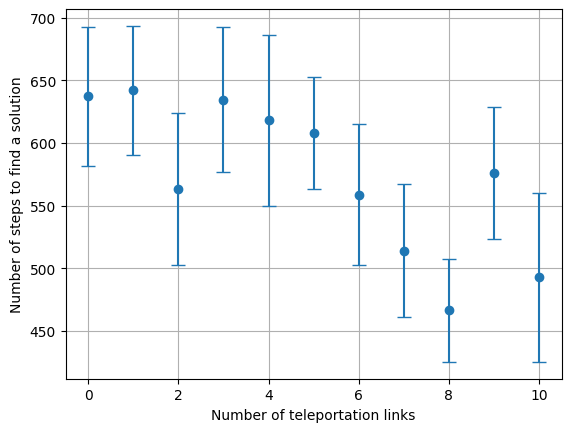

In [41]:
# use("ipympl")
%matplotlib inline
plt.errorbar(M, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), marker="o", linestyle="none", capsize=5)
plt.xlabel("Number of teleportation links")
plt.ylabel("Number of steps to find a solution")
plt.grid()

plt.savefig(os.path.join(series_dir, "MPlot.png"))

In [21]:
depths_mean = np.mean(solution_depths, axis=1)
depths_std = np.std(solution_depths, axis=1)

In [22]:
depths_mean

array([56.6 , 55.7 , 46.95, 51.4 , 50.3 , 49.85, 50.6 , 46.1 , 43.2 ,
       48.3 , 44.75])

In [ ]:
depths_std / np.sqrt(n_repetitions)

array([2.67058046, 2.01134284, 2.56463935, 2.43351597, 2.55939446,
       1.63596302, 2.34136712, 2.1093838 , 2.05377701, 2.96487774,
       4.00616712])

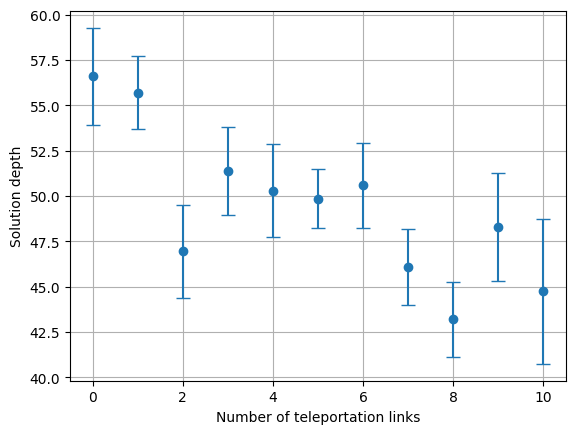

In [ ]:
# use("ipympl")
%matplotlib inline
plt.errorbar(M, depths_mean, depths_std / np.sqrt(n_repetitions), marker="o", linestyle="none", capsize=5)
plt.xlabel("Number of teleportation links")
plt.ylabel("Solution depth")
plt.grid()

# plt.savefig(os.path.join(series_dir, "data.png"))

In [26]:
from scipy.stats import pearsonr

pearson = pearsonr(np.array(solution_n_steps).flatten(), np.array(solution_depths).flatten())

print(pearson)

PearsonRResult(statistic=np.float64(0.7499080227738264), pvalue=np.float64(5.460291363668364e-41))


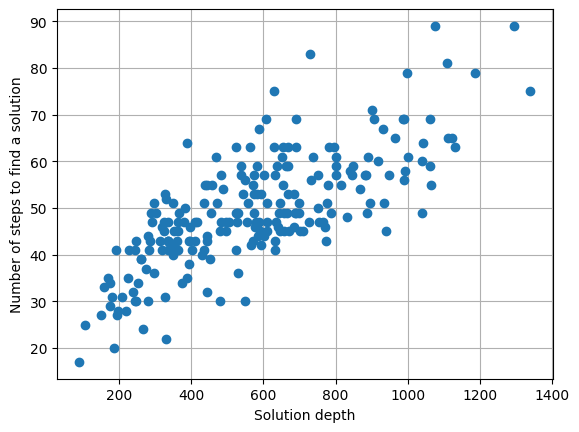

In [39]:
for k in range(n_repetitions):
    plt.plot(np.array(solution_n_steps)[...,k], np.array(solution_depths)[...,k], "oC0")
plt.xlabel("Solution depth")
plt.ylabel("Number of steps to find a solution")
plt.grid()

plt.savefig(os.path.join(series_dir, "MPlot3.png"))

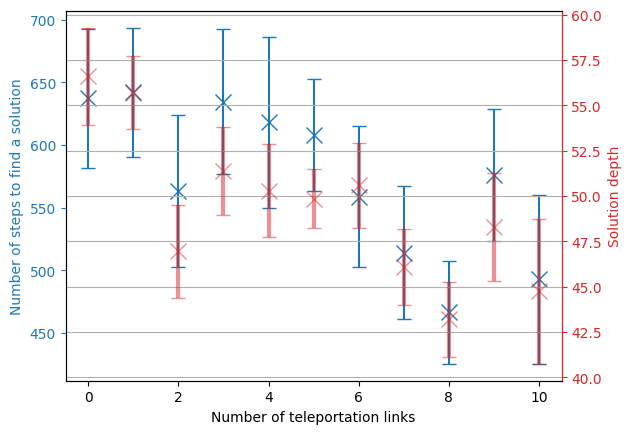

In [38]:
# use("ipympl")
%matplotlib inline
fig, ax = plt.subplots()
ax2 = plt.twinx(ax)

ax.errorbar(M, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), marker="x", color="C0", markersize=12, linestyle="none", capsize=5)
ax2.errorbar(M, depths_mean, depths_std / np.sqrt(n_repetitions), marker="x", color="C3", markersize=12, linestyle="none", elinewidth=3, alpha=0.5, capsize=5)
ax.set_xlabel("Number of teleportation links")
ax.set_ylabel("Number of steps to find a solution")
ax2.set_ylabel("Solution depth")
ax2.grid()

ax.yaxis.label.set_color('C0')        #setting up X-axis label color to yellow
ax2.yaxis.label.set_color('C3')          #setting up Y-axis label color to blue

ax.tick_params(axis='y', colors='C0')    #setting up X-axis tick color to red
ax2.tick_params(axis='y', colors='C3')  #setting up Y-axis tick color to black

ax.spines['left'].set_color('C0')        # setting up Y-axis tick color to red
ax2.spines['right'].set_color('C3')         #setting up above X-axis tick color to red

plt.savefig(os.path.join(series_dir, "MPlot2.png"))

### Full Results Analysis

In [ ]:
series = ["M01", "M02"]

solution_n_steps = []
solution_depths = []
for s in series:
    series_dir = os.path.join("solved", s)
    results_filepath = os.path.join(series_dir, "data.json")
    with open(results_filepath, 'r') as file:
        data = json.load(file)
        these_n_steps = data["solution_n_steps"]
        these_depths = data["solution_depths"]
    solution_n_steps.append(these_n_steps)
    solution_depths.append(these_depths)

In [ ]:
solution_n_steps = np.array(solution_n_steps)
solution_n_steps = solution_n_steps.swapaxes(0,1)
solution_n_steps = solution_n_steps.reshape(len(solution_n_steps), -1)

solution_depths = np.array(solution_depths)
solution_depths = solution_depths.swapaxes(0,1)
solution_depths = solution_depths.reshape(len(solution_depths), -1)

In [6]:
n_steps_mean = np.mean(solution_n_steps, axis=1)
n_steps_std = np.std(solution_n_steps, axis=1)

In [7]:
n_steps_mean

array([545.85 , 519.75 , 443.825, 492.9  , 460.525, 453.325, 468.775,
       469.9  , 480.875, 429.55 , 420.5  ])

In [8]:
n_steps_std / np.sqrt(n_repetitions*len(series))

array([37.37168965, 40.21384634, 27.97326598, 35.18802708, 28.13367616,
       34.21244999, 43.58096614, 35.46307587, 39.24578301, 30.17981424,
       30.60951649])

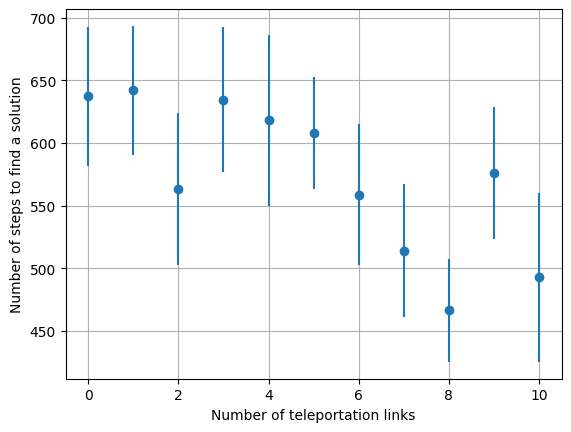

In [ ]:
# use("ipympl")
%matplotlib inline
plt.errorbar(M, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), marker="o", linestyle="none")
plt.xlabel("Number of teleportation links")
plt.ylabel("Number of steps to find a solution")
plt.grid()

# plt.savefig(os.path.join(results_dir, "MPlot.png"))

In [10]:
depths_mean = np.mean(solution_depths, axis=1)
depths_std = np.std(solution_depths, axis=1)

In [11]:
depths_mean

array([58.35 , 52.975, 52.4  , 53.575, 49.025, 46.85 , 47.4  , 50.25 ,
       45.825, 46.675, 44.575])

In [12]:
depths_std / np.sqrt(n_repetitions*len(series))

array([1.75981178, 1.62384093, 1.43996528, 1.61898406, 1.94051781,
       1.69061749, 2.29777066, 1.81959817, 1.99777611, 1.45833274,
       1.88344349])

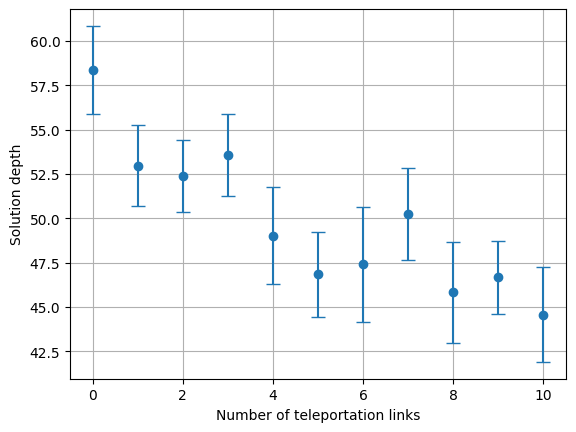

In [ ]:
# use("ipympl")
%matplotlib inline
plt.errorbar(M, depths_mean, depths_std / np.sqrt(n_repetitions), marker="o", linestyle="none", capsize=5)
plt.xlabel("Number of teleportation links")
plt.ylabel("Solution depth")
plt.grid()

# plt.savefig(os.path.join(results_dir, "data.png"))

In [ ]:
from scipy.stats import pearsonr

pearson = pearsonr(solution_n_steps.flatten(), solution_depths.flatten())

print(pearson)

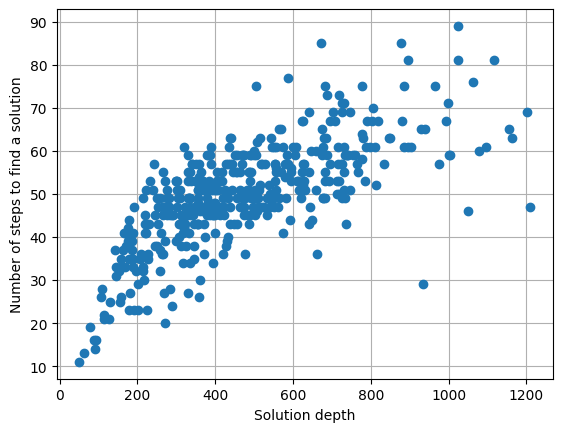

In [ ]:
for k in range(n_repetitions*2):
    plt.plot(solution_n_steps[...,k], solution_depths[...,k], "oC0")
plt.xlabel("Solution depth")
plt.ylabel("Number of steps to find a solution")
plt.grid()

# plt.savefig(os.path.join("solved", "data3.png"))

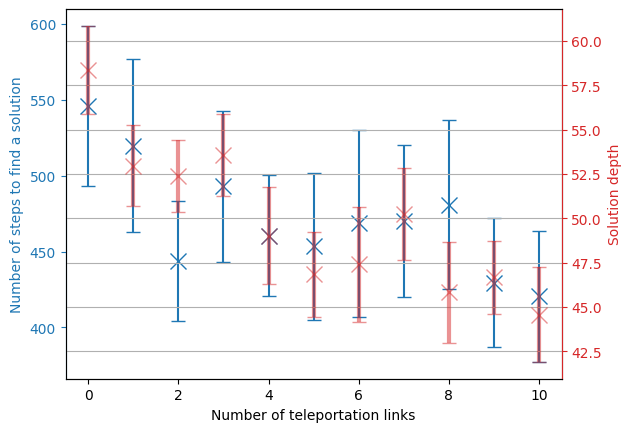

In [ ]:
# use("ipympl")
%matplotlib inline
fig, ax = plt.subplots()
ax2 = plt.twinx(ax)

ax.errorbar(M, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), marker="x", color="C0", markersize=12, linestyle="none", capsize=5)
ax2.errorbar(M, depths_mean, depths_std / np.sqrt(n_repetitions), marker="x", color="C3", markersize=12, linestyle="none", elinewidth=3, alpha=0.5, capsize=5)
ax.set_xlabel("Number of teleportation links")
ax.set_ylabel("Number of steps to find a solution")
ax2.set_ylabel("Solution depth")
ax2.grid()

ax.yaxis.label.set_color('C0')        #setting up X-axis label color to yellow
ax2.yaxis.label.set_color('C3')          #setting up Y-axis label color to blue

ax.tick_params(axis='y', colors='C0')    #setting up X-axis tick color to red
ax2.tick_params(axis='y', colors='C3')  #setting up Y-axis tick color to black

ax.spines['left'].set_color('C0')        # setting up Y-axis tick color to red
ax2.spines['right'].set_color('C3')         #setting up above X-axis tick color to red

# plt.savefig(os.path.join("solved", "data2.png"))

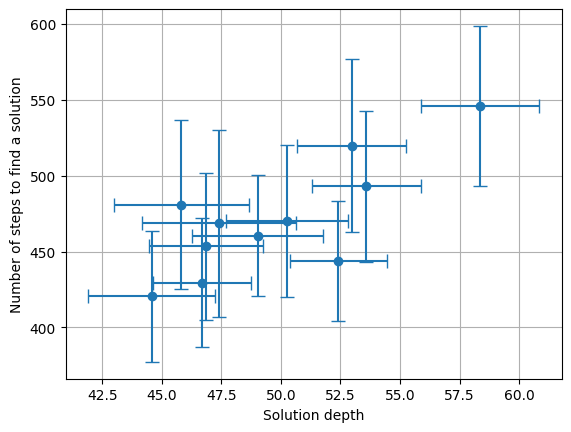

In [ ]:
# use("ipympl")
%matplotlib inline
plt.errorbar(depths_mean, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), depths_std / np.sqrt(n_repetitions), marker="o", linestyle="none", capsize=5)
plt.xlabel("Solution depth")
plt.ylabel("Number of steps to find a solution")
plt.grid()

# plt.savefig(os.path.join("solved", "data4.png"))

Beta: [ 7.5739569 89.3050943]
Beta Std Error: [ 1.9695048 98.1477491]
Beta Covariance: [[ 1.66617379e+01 -8.27903113e+02]
 [-8.27903113e+02  4.13777527e+04]]
Residual Variance: 0.2328057962048221
Inverse Condition #: 0.012899448657720539
Reason(s) for Halting:
  Sum of squares convergence
R Squared 0.6021615725789358


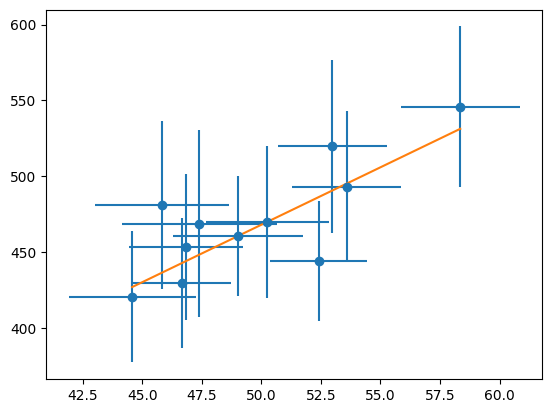

In [ ]:
import scipy.odr as odr
import random

# Define a function (quadratic in our case) to fit the data with.
def linear_function(params, x):
     m, b = params
     return m*x + b

# Create a model for fitting.
quad_model = odr.Model(linear_function)

# Create a RealData object using our initiated data from above.
data = odr.RealData(depths_mean, n_steps_mean, sy=n_steps_std/np.sqrt(n_repetitions), sx=depths_std/np.sqrt(n_repetitions))

# Set up ODR with the model and data.
odr = odr.ODR(data, quad_model, beta0=[0., 1.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

x_fit = np.linspace(depths_mean.min(), depths_mean.max(), 20)
y_fit = linear_function(out.beta, x_fit)

plt.errorbar(depths_mean, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), depths_std / np.sqrt(n_repetitions), marker="o", linestyle="none")
plt.plot(x_fit, y_fit)

rsq = 1 - sum( (n_steps_mean - linear_function(out.beta, depths_mean))**2 )/sum( (n_steps_mean - np.mean(n_steps_mean))**2 )
print("R Squared", rsq)

plt.grid()
plt.show()